# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2022**

**Мягкий дедлайн: 03.06.2022 23:59 MSK**

**Жёсткий дедлайн: 08.06.2022 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def get_pk(relevant: List[List[int]], predicted: List[List[int]], k: int):
    pk = []
    for r, pr in zip(relevant, predicted):
        pk += [np.cumsum(np.isin(pr[:k], r)) / np.arange(1, k + 1)]
    return pk

def get_apk(relevant: List[List[int]], predicted: List[List[int]], k: int):
    apk = []
    pk = get_pk(relevant, predicted, k)
    for r, pr, pku in zip(relevant, predicted, pk):
        apk += [np.sum(np.isin(pr[:k], r) * pku) / min(len(r), k)]
    return apk

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    apk = get_apk(relevant, predicted, k)
    return np.mean(apk)


In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for uid in range(self.n_users):
            test_preds += [self.recommend(uid)]
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def pearson(ratings: np.array, user_vector: np.array):
    return np.array(list(
        r @ user_vector / (np.sqrt(r @ r * user_vector @ user_vector)) for r in ratings))

def jaccard(ratings: np.array, user_vector: np.array):
    return np.array(list(
        len(np.where((r > 0) & (user_vector > 0))[0]) /
        len(np.where((r > 0) | (user_vector > 0))[0])
            for r in ratings))

In [16]:
rat = np.array([
    [0, 1, 1, 1, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 0, 1, 1]
])
us = rat[-1]
jaccard(rat, us), pearson(rat, us)

(array([0.6 , 0.75, 1.  ]), array([0.75     , 0.8660254, 1.       ]))

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [17]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        # Убрал ассерт, чтобы функции для sparse

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        n = np.where(sim > self.alpha)[0]
        n = n[n != uid]
        res = sim[n] @ self.R[n]
        return np.argsort(-res)

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [18]:
cnt = 50
u2u_pearson = User2User(train_ratings, pearson)
results_pearson = u2u_pearson.get_test_recommendations(cnt)

In [19]:
u2u_jaccard = User2User(train_ratings, jaccard)
results_jaccard = u2u_jaccard.get_test_recommendations(cnt)

In [20]:
results_random = np.array(list(np.random.choice(
    ratings['trackId'].unique(), cnt) for _ in test_users))

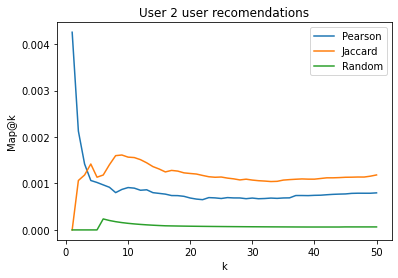

In [21]:
default_range = range(1, cnt + 1)
plt.plot(default_range, list(mapk(test_relevant, results_pearson, k) for k in default_range), label='Pearson')
plt.plot(default_range, list(mapk(test_relevant, results_jaccard, k) for k in default_range), label='Jaccard')
plt.plot(default_range, list(mapk(test_relevant, results_random, k) for k in default_range), label='Random')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.title('User 2 user recomendations')
plt.show()

**Бонус (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [22]:
from scipy.sparse import csr_matrix, find

def pearson_sparse(ratings: csr_matrix, user_vector: csr_matrix):
    uv_reshaped = user_vector.reshape(-1, 1)
    return np.array(list(
        ((r @ uv_reshaped / (np.sqrt(
            (r @ r.reshape(-1, 1)) *
            (user_vector @ uv_reshaped)))).sum() for r in ratings)))

def jaccard_sparse(ratings: csr_matrix, user_vector: csr_matrix):
    return np.array(list(
        len(np.intersect1d(find(r)[1], find(user_vector)[1])) /
        len(find(r + user_vector > 0)[0])
            for r in ratings))

class User2UserSparse(User2User):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, similarity_func)
        self.R = csr_matrix(self.R)

u2u = User2UserSparse(train_ratings, pearson_sparse)
result_p_sp = u2u.get_test_recommendations(cnt)

In [23]:
u2u = User2UserSparse(train_ratings, jaccard_sparse)
result_p_jc = u2u.get_test_recommendations(cnt)

In [24]:
assert (result_p_jc == results_jaccard).all()
assert (result_p_sp == results_pearson).all()

Скорость значительно ниже (может я криворукий).

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [30]:
model = User2User(train_ratings, jaccard)

In [31]:
user_id = np.random.randint(0, model.n_users)

In [32]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
23,Fortunate Son,['Creedence Clearwater Revival']
81,Ain't No Mountain High Enough,"['Marvin Gaye', 'Tammi Terrell']"
95,Paranoid,['Black Sabbath']
217,Detroit Rock City,['Kiss']
224,Tiny Dancer,['Elton John']
258,What A Wonderful World,['Louis Armstrong']
357,Inside Out,['Bryan Adams']
384,Sultans Of Swing,['Dire Straits']
388,Money For Nothing,['Dire Straits']
418,Without Me,['Eminem']


In [33]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
4032,Bring Me To Life,['Evanescence']
40209,Выхода нет,['Сплин']
49577,Кукла колдуна,['Король и Шут']
4744,Hero,['Skillet']
1666,Faint,['Linkin Park']
2813,Breaking the Habit,['Linkin Park']
1131,The Unforgiven,['Metallica']
3574,Eye of the Tiger,['Survivor']
2755,Snow (Hey Oh),['Red Hot Chili Peppers']
12266,Radioactive,['Imagine Dragons']


In [34]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
57150,"The Messiah Will Come Again"" ""Shine on You Cra...","['Izzo Blues Coalition', 'David Gilmour', 'Rog..."
57401,Сансара,"['Александр Петров', 'Moscow Gospel Team', 'Юр..."
57699,Стюардесс,['Моя Мишель']
57847,Держава,['Василий К.']
58043,Lonely,['Palaye Royale']
58121,Русская дорога,['Игорь Растеряев']
58123,Богатыри,['Игорь Растеряев']
58124,Комбайнёры,['Игорь Растеряев']
58125,Георгиевская ленточка,['Игорь Растеряев']
58541,August,['Intelligency']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 6 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

$
\nabla_{p_u} L = 2\sum\limits_i (p_u^Tq_i^2 - r_{ui}q_i) + 2\lambda p_u$

$
\nabla_{q_u} L = 2\sum\limits_u (q_i^Tp_u^2 - r_{ui}p_u) + 2\lambda p_u$

Стахонический град. спуск $\Rightarrow$

$
p_{u\ new} = p_u - 2step(p_u^Tq_i^2 - r_{ui}q_i + \lambda p_u)$

$
q_{i\ new} = q_i - 2step(q_i^Tp_u^2 - r_{ui}p_u + \lambda q_i)$

**ALS:**

$
L = ||(R - P^TQ)||_F^2 + \lambda(||P||_F^2 + ||Q||_F^2)\\
d_PL = d(tr((R - P^TQ)^T(R - P^TQ))) + d\lambda tr(P^TP) =\\
2tr((R - P^TQ)^Td(R - P^TQ)) + \lambda tr(P^TdP) =
2tr((R - P^TQ)^T(-dP^TQ)) + tr(\lambda P^TdP) =\\
tr(2((P^TQ - R)Q^T + \lambda P^T)dP)\\
\nabla_P L = 2(Q(P^TQ - R)^T + \lambda P)\\
d_Q L = tr(2((P^TQ - R)^TP^T + \lambda Q^T)dQ)\\
\nabla_Q L = 2(P(P^TQ - R) + \lambda Q)\\
$

Решаем:

$
2(Q(P^TQ - R)^T + \lambda P) = 0\\
QQ^TP + \lambda P = QR^T\\
P = (QQ^T + \lambda)^{-1}QR^T\\
2(P(P^TQ - R) + \lambda Q) = 0\\
PP^T Q + \lambda Q = PR\\
Q = (PP^T + \lambda)^{-1}PR\\
$

**Задание 7 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [210]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, lr=0.0003, lamb=0.01, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        # ALS required in other dimensions
        self.P = np.random.normal(size=(dim, self.n_users))
        self.Q = np.random.normal(size=(dim, self.n_items))

        self.lr = lr
        self.lamb = lamb

    def _fit_sgd(self):
        u = np.random.randint(0, self.n_users)
        i = np.random.randint(0, self.n_items)
        p = self.P[:, u]
        q = self.Q[:, i]
        dot_product = p @ q
        self.P[:, u] = p - 2 * self.lr * (dot_product * q - self.R[u][i] * q + self.lamb * p)
        self.Q[:, i] = q - 2 * self.lr * (dot_product * p - self.R[u][i] * p + self.lamb * q)

    def _fit_als(self):
        self.P = np.linalg.inv(self.Q @ self.Q.T + self.lamb * np.eye(self.dim)) @ self.Q @ self.R.T
        self.Q = np.linalg.inv(self.P @ self.P.T + self.lamb * np.eye(self.dim)) @ self.P @ self.R

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                self._fit_sgd()
            elif self.mode == 'als':
                self._fit_als()

    def recommend(self, uid):
        # Because of transposed in init
        pred_rating = self.Q.T @ self.P[:, uid]
        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [213]:
import optuna
from IPython.display import clear_output

def get_train_and_test(mode):
    def train_and_test_sgd(trial):
        model_kwargs = {
            'mode': mode,
            'dim': trial.suggest_int('dim', 5, 1000),
            'lamb': trial.suggest_float('lamb', 1e-7, 1e-1),
        }
        if mode == 'sgd':
            model_kwargs.update({'lr': trial.suggest_float('lr', 1e-7, 1e-1)})
        model = HiddenVars(
            train_ratings,
            **model_kwargs
        )
        if mode == 'sgd':
            model.fit(trial.suggest_int('iters', 5, 100000))
        else:
            model.fit(trial.suggest_int('iters', 5, 50))
        result = model.get_test_recommendations(50)
        best_mapk = 0
        for k in default_range:
            cur_mapk = mapk(test_relevant, result, k)
            if cur_mapk > best_mapk:
                best_mapk = cur_mapk

        return best_mapk

    return train_and_test_sgd

In [214]:
study_sgd = optuna.create_study(direction='maximize')
study_sgd.optimize(get_train_and_test('sgd'), n_trials=25)
clear_output()
print('Best params for sgd:', study_sgd.best_params, '\nBest value:', study_sgd.best_value)

Best params for sgd: {'dim': 276, 'lamb': 0.043480200054032025, 'lr': 0.03746113989962968, 'iters': 99318} 
Best value: 0.01276595744680851


In [215]:
study_als = optuna.create_study(direction='maximize')
study_als.optimize(get_train_and_test('als'), n_trials=25)
clear_output()
print('Best params for als:', study_als.best_params, '\nBest value:', study_als.best_value)

Best params for als: {'dim': 284, 'lamb': 0.041035372491186266, 'iters': 33} 
Best value: 0.00851063829787234


In [220]:
def get_trained_models(mode, trial):
    model_kwargs = {
        'mode': mode,
        'dim': trial.suggest_int('dim', 5, 1000),
        'lamb': trial.suggest_float('lamb', 1e-7, 1e-1),
    }
    if mode == 'sgd':
        model_kwargs.update({'lr': trial.suggest_float('lr', 1e-7, 1e-1)})
    model = HiddenVars(
        train_ratings,
        **model_kwargs
    )
    if mode == 'sgd':
        model.fit(trial.suggest_int('iters', 5, 100000))
    else:
        model.fit(trial.suggest_int('iters', 5, 50))
    return model

model_sgd = get_trained_models('sgd', study_sgd.best_trial)
model_als = get_trained_models('als', study_als.best_trial)
clear_output()

In [222]:
result_sgd = model_sgd.get_test_recommendations(50)
result_als = model_als.get_test_recommendations(50)

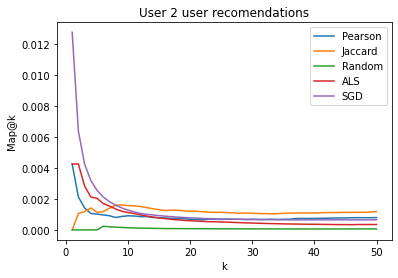

In [223]:
default_range = range(1, cnt + 1)
plt.plot(default_range, list(mapk(test_relevant, results_pearson, k) for k in default_range), label='Pearson')
plt.plot(default_range, list(mapk(test_relevant, results_jaccard, k) for k in default_range), label='Jaccard')
plt.plot(default_range, list(mapk(test_relevant, results_random, k) for k in default_range), label='Random')
plt.plot(default_range, list(mapk(test_relevant, result_als, k) for k in default_range), label='ALS')
plt.plot(default_range, list(mapk(test_relevant, result_sgd, k) for k in default_range), label='SGD')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.title('User 2 user recomendations')
plt.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [298]:
# У SGD очень много nan на выходе поэтому что-то странное получилось
model = model_als

In [302]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q.T @ model.Q[:, example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=0) + 1e-8)
track_idxs = preds.argsort()[::-1][:20]

In [303]:
# Для SGD вытаскивал не nan, но в целом так себе получилось
# track_idxs = preds.argsort()[::-1][48650:48670]

In [304]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[:, example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.644610
5153,Stormbringer,['Deep Purple'],0.587404
9689,Bicycle Race,['Queen'],0.587404
16637,Zodiac,['Zodiac'],0.587404
5570,Моё сердце,['Сплин'],0.580430
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.563696
10282,Владивосток 2000,['Мумий Тролль'],0.544653
13264,Безобразная Эльза,['Крематорий'],0.542845
13263,Мусорный ветер,['Крематорий'],0.542845


**Бонус (0.01 балла).** Опишите свои впечатления от коллоквиума. Что следует поменять, чтобы впечатления стали лучше?

норм, оценку повысить. Ы